In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["font.family"] = "Arial"

from scipy.io import savemat, loadmat
from scipy.ndimage import gaussian_filter1d as gf1d
import colorsys

import tensorflow as tf
print(tf. __version__)

2.10.0


## Load data

In [2]:
def RBF(d,lmbda):
    return np.exp(-d**2/2/lmbda**2)

def mldivide(A,B):
    return np.linalg.pinv(A).dot(B)
    
def sm_GP(qq,f,lmbda,sigma):
    d_ij = qq.reshape(len(qq),1) - qq.reshape(1,len(qq))
    
    K = RBF(d_ij,lmbda)
    K_s = K
    K_y = K + np.eye(len(qq))*sigma**2
    
    y = f
    L = np.linalg.cholesky(K_y)

    alpha = mldivide(L.T,mldivide(L,y))
    E = K_s.T@alpha
    
    return E

In [3]:
#### Meshgrid ####
n_grid = 100
x = np.linspace(-1,1,n_grid+1)
y = np.linspace(-1,1,n_grid+1)
z = np.linspace(-1,1,n_grid+1)

r_grid = np.meshgrid(x,y,z) 

# calculate scattering function
box_size = 2
n_grid_scale = 256
scale = n_grid_scale/r_grid[0].shape[0]
dq = 2*np.pi/box_size
qq = np.arange(n_grid_scale/2)*dq

#################################
S_q_Grid = []
p_Grid = []
for i in range(10):
    #### load data ####
    filename = '../training_set/alpha/grid/S_q_{}.mat'.format(i)
    data = loadmat(filename)
    k_grid = data['k_grid']
    S_q_kxy = data['S_q_kxy']
    
    S_q_Grid.append(S_q_kxy)
    p_Grid.append(k_grid)

for i in range(10):
    #### load data ####
    filename = '../training_set/alpha/grid/S_q_{}.5.mat'.format(i)
    data = loadmat(filename)
    k_grid = data['k_grid']
    S_q_kxy = data['S_q_kxy']
    
    S_q_Grid.append(S_q_kxy)
    p_Grid.append(k_grid)

S_q_Grid = np.array(S_q_Grid).reshape(100*len(p_Grid),128)[:,1:-1].astype(np.float32)
p_Grid = np.array(p_Grid).reshape(100*len(p_Grid),3)
S_q_sm_Grid = np.exp(np.array([gf1d(f,1,mode='nearest') for f in np.log(S_q_Grid)])).astype(np.float32)
log_S_q_Grid = np.log(S_q_Grid)
log_S_q_sm_Grid = np.log(S_q_sm_Grid)

k_z = p_Grid[:,0].astype(np.float32)
alpha = p_Grid[:,1].astype(np.float32)
kappa = p_Grid[:,2].astype(np.float32)
logkappa = np.log(kappa).astype(np.float32)
set_k_z = np.unique(k_z)
set_alpha = np.unique(alpha)
set_kappa = np.flip(np.unique(kappa))

print('\nk_z in')
print(set_k_z)
print('\nalpha in')
print(set_alpha)
print('\nkappa in')
print(set_kappa)

#################################
S_q_Rand = []
p_Rand = []
for i in range(10):
    #### load data ####
    filename = '../training_set/alpha/Rand/S_q_Rand_{}.mat'.format(i)
    data = loadmat(filename)
    k_grid = data['k_grid']
    S_q_kxy = data['S_q_kxy']
    
    S_q_Rand.append(S_q_kxy)
    p_Rand.append(k_grid)

S_q_Rand = np.array(S_q_Rand).reshape(100*len(p_Rand),128)[:,1:-1]
p_Rand = np.array(p_Rand).reshape(100*len(p_Rand),3)
S_q_sm_Rand = np.exp(np.array([gf1d(f,1,mode='nearest') for f in np.log(S_q_Rand)]))
log_S_q_Rand = np.log(S_q_Rand)
log_S_q_sm_Rand = np.log(S_q_sm_Rand)

k_z_Rand = p_Rand[:,0].astype(np.float32)
alpha_Rand = p_Rand[:,1].astype(np.float32)
kappa_Rand = p_Rand[:,2].astype(np.float32)
logkappa_Rand = np.log(kappa_Rand)


k_z in
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]

alpha in
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45]

kappa in
[128.          90.50967     64.          45.254833    32.
  22.627417    16.          11.313708     8.           5.656854
   4.           2.828427     2.           1.4142135    1.
   0.70710677   0.5          0.35355338   0.25         0.17677669]


In [4]:
# indexing
def id_params(parameters):
    tol = 1e-6
    id_k_z = np.abs(k_z-parameters[0])<tol
    id_alpha = np.abs(alpha-parameters[1])<tol
    id_kappa = np.abs(kappa-parameters[2])<tol
    return np.where(id_k_z*id_alpha*id_kappa)[0][0]

# color
def color_params(parameters):
    k_z_reduced = (parameters[0]-1)/10
    alpha_reduced = parameters[1]/0.5
    kappa_reduced = np.log(128/parameters[2])/10
    return [k_z_reduced, kappa_reduced, alpha_reduced]

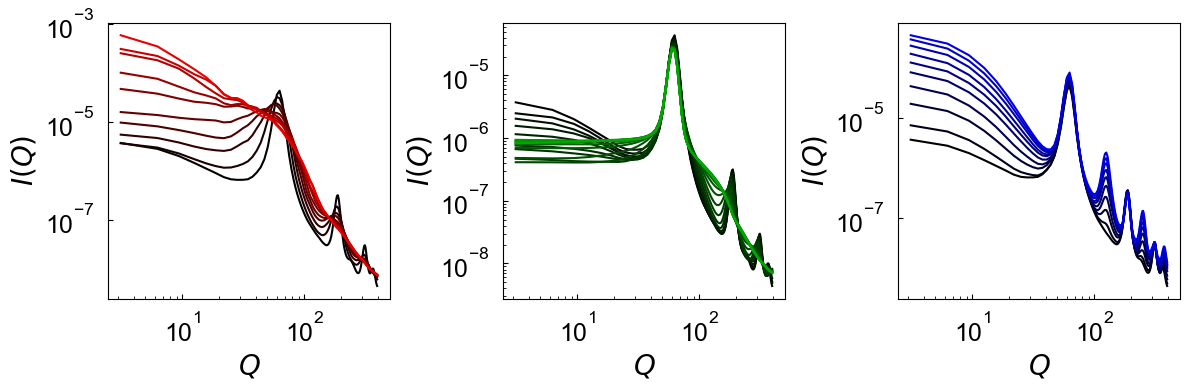

In [5]:
def plot_data_all():
    ## plot results: varying k_z
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot(1,3,1)

    for i, k_z_i in enumerate(set_k_z):
        parameters = [k_z_i,set_alpha[0],set_kappa[0]]
        index = id_params(parameters)
        
        color = color_params(parameters)

        ax.plot(qq[1:-1],S_q_sm_Grid[index,],'-',color=color)

    ax.set_xlabel(r'$Q$',fontsize=20)
    ax.set_ylabel(r'$I(Q)$',fontsize=20)
    ax.set_yscale('log')
    ax.set_xscale('log')
    # ax.set_xlim([0,100])
    # ax.set_ylim([1e-6,2e0])
    ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

    ax = fig.add_subplot(1,3,2)

    for i, kappa_i in enumerate(set_kappa):
        parameters = [set_k_z[0],set_alpha[0],kappa_i]
        index = id_params(parameters)
        
        color = color_params(parameters)

        ax.plot(qq[1:-1],S_q_sm_Grid[index,],'-',color=color)

    ax.set_xlabel(r'$Q$',fontsize=20)
    ax.set_ylabel(r'$I(Q)$',fontsize=20)
    ax.set_yscale('log')
    ax.set_xscale('log')
    # ax.set_xlim([0,100])
    # ax.set_ylim([1e-6,2e0])
    ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

    ax = fig.add_subplot(1,3,3)

    for i, alpha_i in enumerate(set_alpha):
        parameters = [set_k_z[0],alpha_i,set_kappa[0]]
        index = id_params(parameters)
        
        color = color_params(parameters)

        ax.plot(qq[1:-1],S_q_sm_Grid[index,],'-',color=color)

    ax.set_xlabel(r'$Q$',fontsize=20)
    ax.set_ylabel(r'$I(Q)$',fontsize=20)
    ax.set_yscale('log')
    ax.set_xscale('log')
    # ax.set_xlim([0,100])
    # ax.set_ylim([1e-6,2e0])
    ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

    plt.tight_layout()
    plt.show()

plot_data_all()

In [6]:
k_z_mean = np.mean(k_z)
k_z_std = np.std(k_z)
k_z_z = (k_z-k_z_mean)/k_z_std

kappa_mean = np.mean(logkappa)
kappa_std = np.std(logkappa)
kappa_z = (logkappa-kappa_mean)/kappa_std

alpha_mean = np.mean(alpha)
alpha_std = np.std(alpha)
alpha_z = (alpha-alpha_mean)/alpha_std

k_z_Rand_mean = np.mean(k_z_Rand)
k_z_Rand_std = np.std(k_z_Rand)
k_z_Rand_z = (k_z_Rand-k_z_Rand_mean)/k_z_Rand_std

kappa_Rand_mean = np.mean(logkappa_Rand)
kappa_Rand_std = np.std(logkappa_Rand)
kappa_Rand_z = (logkappa_Rand-kappa_Rand_mean)/kappa_Rand_std

alpha_Rand_mean = np.mean(alpha_Rand)
alpha_Rand_std = np.std(alpha_Rand)
alpha_Rand_z = (alpha_Rand-alpha_Rand_mean)/alpha_Rand_std

parameters_zscore = 1
if parameters_zscore:
    parameters_train = np.array([k_z_z,kappa_z,alpha_z]).T
else:
    parameters_train = np.array([k_z,logkappa,alpha]).T

if parameters_zscore:
    parameters_test = np.array([k_z_Rand_z,kappa_Rand_z,alpha_Rand_z]).T
else:
    parameters_test = np.array([k_z_Rand,logkappa_Rand,alpha_Rand]).T

In [7]:
# shuffle data
train_size = len(k_z)
test_size = len(k_z_Rand)
print('training set size = {} \ntest set size = {}'.format(train_size,test_size))

batch_size = 64
batch_size_test = 1000

train_SQ_dataset = (tf.data.Dataset.from_tensor_slices(log_S_q_Grid)
                 .shuffle(train_size, seed=6174).batch(batch_size))
test_SQ_dataset = (tf.data.Dataset.from_tensor_slices(log_S_q_Rand)
                .shuffle(test_size, seed=6174).batch(batch_size_test))

train_parameters_dataset = (tf.data.Dataset.from_tensor_slices((parameters_train))
                 .shuffle(train_size, seed=6174).batch(batch_size))
test_parameters_dataset = (tf.data.Dataset.from_tensor_slices((parameters_test))
                .shuffle(test_size, seed=6174).batch(batch_size_test))

# no random
i = 0
for test_SQ_batch in train_SQ_dataset:
    if i == 15:
        test_SQ_sample = test_SQ_batch[0:16, :]
    i+=1
i = 0
for test_parameters_batch in train_parameters_dataset:
    if i == 15:
        test_parameters_sample = test_parameters_batch[0:16, :]
    i+=1

training set size = 2000 
test set size = 1000


## Train generative NN

In [8]:
from train_NN import Train_NN_V
## Transform the input to tensorflow tensor
def to_tf(arg):
    arg = tf.convert_to_tensor(arg, dtype=tf.float32)
    return arg

# -20 to -6
f_shift = -20 
f_scale = 16

def f_inp(sq):
    return (sq-f_shift)/f_scale

def f_out(sq_pred):
    return (sq_pred*f_scale)+f_shift

In [9]:
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, sq_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        regularizer = tf.keras.regularizers.L2(1.0)
        self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(sq_dim)),
            tf.keras.layers.Reshape((sq_dim,1)),
            tf.keras.layers.Conv1D(
                filters=48, kernel_size=3, strides=2, activation='relu',
                kernel_regularizer = regularizer,
                bias_regularizer = regularizer,
                name='conv1d_en'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(
                latent_dim + latent_dim, 
                kernel_regularizer = regularizer,
                bias_regularizer = regularizer,
                name='dense_en'),
        ]
        )
        
        self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(
                int(sq_dim/2)*48, activation=tf.nn.relu, 
                kernel_regularizer = regularizer,
                bias_regularizer = regularizer,
                name='dense_de'),
            tf.keras.layers.Reshape(target_shape=(int(sq_dim/2), 48)),
            tf.keras.layers.Conv1DTranspose(
                filters=48, kernel_size=3, strides=2, padding='same', activation='relu',
                kernel_regularizer = regularizer,
                bias_regularizer = regularizer,
                name='conv1dtrs_de'),
            tf.keras.layers.Conv1DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
            tf.keras.layers.Reshape((sq_dim,))
        ]
        )

In [10]:
latent_dim = 3
q_rs_dim = len(qq)-2

# Decoder layers
model_VAE = VAE(latent_dim, q_rs_dim)
model_decoder = model_VAE.decoder
model_decoder.summary()

# Augmented layers
# Add a dense layer to pre-trained decoder
regularizer = tf.keras.regularizers.L2(1.0)
dense_3 = [
    tf.keras.layers.InputLayer(input_shape=(3)),
    tf.keras.layers.Dense(6, 
                kernel_regularizer = regularizer,
                bias_regularizer = regularizer,
                name='dense_in'),
    tf.keras.layers.Dense(6, 
                kernel_regularizer = regularizer,
                bias_regularizer = regularizer,
                name='dense_in2'),]

# # rescaling the dense layer to the value range of decoder input
# rescale = [tf.keras.layers.Rescaling(scale=1.0, offset=0.0)]
# rescale[0].trainable = False

model_aug = tf.keras.Sequential(dense_3)#+rescale)
model_aug.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_de (Dense)            (None, 3024)              12096     
                                                                 
 reshape_1 (Reshape)         (None, 63, 48)            0         
                                                                 
 conv1dtrs_de (Conv1DTranspo  (None, 126, 48)          6960      
 se)                                                             
                                                                 
 conv1d_transpose (Conv1DTra  (None, 126, 1)           145       
 nspose)                                                         
                                                                 
 reshape_2 (Reshape)         (None, 126)               0         
                                                                 
Total params: 19,201
Trainable params: 19,201
Non-trai

In [11]:
class Decoder_aug(tf.keras.Model):
    def __init__(self, latent_dim, sq_dim):
        super(Decoder_aug,self).__init__()
        self.latent_dim = latent_dim
        self.aug_layers = model_aug
        self.decoder_layers = model_decoder
        
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(64, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    
    def encode(self, x):
        mean, logvar = tf.split(self.aug_layers(x), num_or_size_splits=2, axis=1)
        return mean, logvar
        
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder_layers(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits
    
    def sample_normal(self, x):
        mean, logvar = self.encode(x)
        eps = tf.random.normal(shape=(64, self.latent_dim))
        def zsample(e):
            return e*tf.exp(logvar*.5) + mean
        z_samples = tf.map_fn(zsample,eps)
        def logitsample(z):
            return self.decode(z, apply_sigmoid=True)
        logits_samples = tf.map_fn(logitsample,z_samples)
        
        logits_std = tf.math.reduce_std(logits_samples,axis=0)
        logits_mean = tf.math.reduce_mean(logits_samples,axis=0)
        
        return logits_mean, logits_std

In [12]:
model = Decoder_aug(latent_dim=3,sq_dim=q_rs_dim)

In [13]:
@tf.function
def regularizer_loss(model):
    loss=0
    for l in model.layers:
        if hasattr(l,'kernel_regularizer') and l.kernel_regularizer:
            loss+=l.losses[0]
        if hasattr(l,'bias_regularizer') and l.bias_regularizer:
            loss+=l.losses[1]
    return loss

@tf.function
def compute_loss(parameters, SQ, model):
    # SQ rescaled to range [0,1]
    
    mean, logvar = model.encode(parameters)
    eps = model.reparameterize(mean, logvar)
    SQ_pred = model.sample(eps)
    
    err = f_out(SQ_pred)-SQ
    err_l2 = tf.reduce_mean((err)**2)
    
    # reg_loss = (regularizer_loss(model.aug_layers)+regularizer_loss(model.decoder_layers))/(66+11265)*0.2
    
    loss = err_l2 #+ reg_loss
    
    return loss

In [14]:
train_rate = 5e-2
batch_size = 64
batch_size_test = 1000
n_epoch = 500
f_loss=compute_loss

fig_path = './figures/test/'
model_path = './saved_model/test/'

data_train = [train_SQ_dataset,train_parameters_dataset]
data_test = [test_SQ_dataset,test_parameters_dataset]

train_NN_1 = Train_NN_V(n_epoch,batch_size,batch_size_test,train_rate,f_loss,model,
                        data_train, data_test, test_SQ_sample, test_parameters_sample,
                        fig_path,model_path,
                        save_fig=False)
train_NN_1.epoch_prev = 0

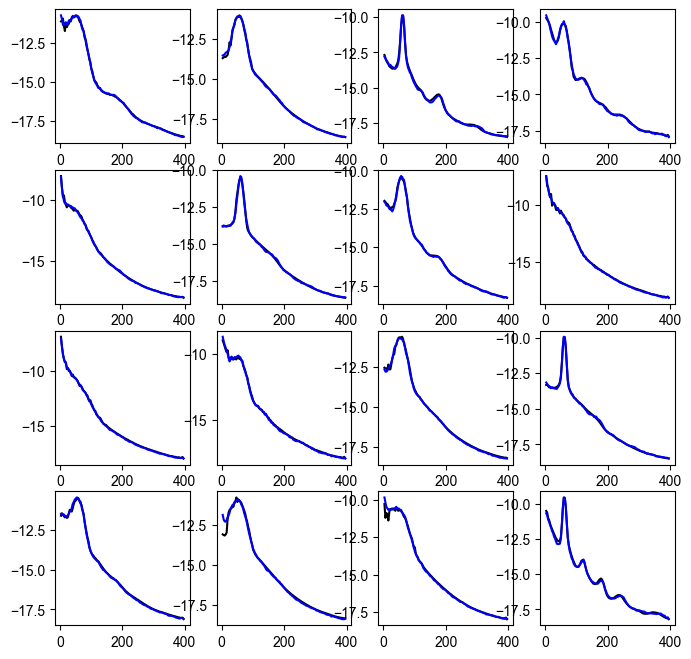

100%|██████████| 500/500 [14:48<00:00,  1.78s/it]


In [15]:
train_NN_1.fit()

In [17]:
train_NN_1.save_model_aug(model_path_sub = 'SQ_Gen_NN/', 
                          model_name='test')
train_NN_1.save_model_decoder(model_path_sub = 'SQ_Gen_NN/', 
                              model_name='test')